This notebook imports and calls the code to clean both global and local outliers, and calls HMMs to segment parallelised on multiple cells. This is currently the best practice to run my tool at date May 4th 2024. 

In [1]:
import os, sys
os.environ["OMP_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 

In [2]:
wd = '/camp/home/patrunl/home/working/patrunl/single_cell_dlp/'
# wd = '/Users/lucrezia/OneDrive - University College London/postdoc/code/lucrezia-dlp-cna'

In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
import warnings
from sklearn.mixture import GaussianMixture
import scipy
from scipy.stats import norm
import sys
sys.path.append(f'{wd}/lucrezia-dlp-cna/src/')
from compute_cnv_hmm import *
from negativebinomial_hmm import *

from sklearn import cluster

from numpy import random

from read_data_utils import *

from statsmodels.tools.eval_measures import bic
from statsmodels.tools.eval_measures import aic

from preprocessing import *

In [4]:
def compute_segment_id(x):
	"""This function takes in input a series x and computes the segment id using x"""
	return (x != x.shift()).cumsum()

def remove_small_segments(x, threshold=2):
	"""This function replaces with NaN the values of the segments that are smaller than the threshold."""
	segment_id = compute_segment_id(x)
	segment_length = segment_id.groupby(segment_id).transform('count')
	x.loc[segment_length <= threshold] = np.NaN
	x.fillna(method='ffill', inplace=True)
	return x

def compute_segment_length(x):
	l = x.shape[0] 
	l = l if l > 2 else None
	return l

def compute_segment_dispersion(x):
	l = x.std() / x.mean()
	return l

In [5]:
os.chdir(f'{wd}/funnel_data/')

results_dir = './../NB_HMM_results/'
os.makedirs(results_dir, exist_ok=True)

In [6]:
run = True # Set to True to run the parallelised HMM

In [7]:
funnel_path = '/nemo/project/proj-tracerx-lung/tctProjects/zaccariaLab/ccg_lab/datasets/Funnell2022'
metrics = pd.read_csv(f'{funnel_path}/signatures_dataset/DLP/metadata/metrics.csv.gz')
metrics.head()

/tmp/ipykernel_358224/1393409625.py:2: DtypeWarning: Columns (78) have mixed types. Specify dtype option on import or set low_memory=False.
  metrics = pd.read_csv(f'{funnel_path}/signatures_dataset/DLP/metadata/metrics.csv.gz')


,cell_id,average_distance,ploidy,totalhapcounts,nsegments,multiplier,MSRSI_non_integerness,MBRSI_dispersion_non_integerness,MBRSM_dispersion,autocorrelation_hmmcopy,...,is_tumour_cell,sample_id,library_id,is_control,expected,overlap_without_dups,overlap_with_dups,overlap_with_all_filters_and_qual,overlap_with_all_filters,aligned
0,SA604X6XB01972-A96177C-R55-C31,0.007229,4,273994,111,4,0.166627,0.403415,0.387465,0.864905,...,True,SA604X6XB01972,A96177C,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SA604X6XB01972-A96177C-R55-C35,0.008123,3,243793,97,3,0.156627,0.432451,0.414525,0.858111,...,True,SA604X6XB01972,A96177C,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SA604X6XB01972-A96177C-R55-C36,0.007466,3,194333,103,3,0.185944,0.441327,0.413386,0.850822,...,True,SA604X6XB01972,A96177C,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SA604X6XB01972-A96177C-R56-C10,0.004182,3,201925,98,3,0.119735,0.428227,0.411172,0.843225,...,True,SA604X6XB01972,A96177C,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SA604X6XB01972-A96177C-R56-C18,0.005605,3,210711,101,3,0.211843,0.431336,0.408137,0.857139,...,True,SA604X6XB01972,A96177C,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# cnas = pd.read_csv(f'{funnel_path}/signatures_dataset/DLP/CNA/hscn_chr.csv.gz')
# cnas.head()

In [9]:
# cnas.columns

In [10]:
segmentation = pd.read_csv(f'{funnel_path}/signatures_dataset/DLP/CNA/persample/SA906a_hscn.csv.gz')
segmentation.head()


,patient,cell_id,chr,start,end,state,copy,state_AS_phased,alleleA,alleleB,totalcounts,BAF,state_min,Maj,Min,LOH,phase,state_phase,state_BAF
0,SA906a,SA906-A96180B-R28-C07,1,1,500000,2,NaN,1|1,NaN,NaN,NaN,NaN,1,1,1,NO,Balanced,Balanced,0.5
1,SA906a,SA906-A96180B-R28-C07,1,500001,1000000,2,NaN,1|1,NaN,NaN,NaN,NaN,1,1,1,NO,Balanced,Balanced,0.5
2,SA906a,SA906-A96180B-R28-C07,1,1000001,1500000,2,2.019732,1|1,NaN,NaN,NaN,NaN,1,1,1,NO,Balanced,Balanced,0.5
3,SA906a,SA906-A96180B-R28-C07,1,1500001,2000000,2,1.964841,1|1,NaN,NaN,NaN,NaN,1,1,1,NO,Balanced,Balanced,0.5
4,SA906a,SA906-A96180B-R28-C07,1,2000001,2500000,2,2.639655,1|1,6.0,6.0,12.0,0.5,1,1,1,NO,Balanced,Balanced,0.5


In [11]:
cell = ['SA501X15XB00929-A96173A-R22-C07']
cell = ['SA906-A96186A-R08-C24']

In [12]:
import pickle
results_nb = pickle.load(open(f'{results_dir}/{cell[0]}_results.pkl', 'rb'))

In [13]:
results_nb[0]['cell_id'].nunique()

402

In [12]:
from parallelize_cells import *
import pickle


if not run:
    file = open(f"{results_dir}/{cell[0]}_results.pkl",'rb')
    test = pickle.load(file)
    file.close()
    norm_data = test[0]
else:
    norm_data = raw_data.copy()
    valid_cells = list(set(norm_data['cell_id']) & set(metrics['cell_id']))
    np.random.seed(seed=123)
    cells = np.random.choice(valid_cells, size = 2, replace=False)
    test_data = norm_data[norm_data['cell_id'].isin(cells)]
libFactors = norm_data.groupby('cell_id')['reads'].sum()
norm_data['library_size'] = norm_data['cell_id'].map(libFactors)

# Compute the fraction of reads that map to that segment in each cell
norm_data['norm_reads'] = (norm_data['reads'] / norm_data['library_size'])   



NameError: name 'raw_data' is not defined

In [15]:
file = open(f"{wd}/lucrezia-dlp-cna/auxiliary_data/res_NBFit_zeroState_13112023.pkl",'rb')
res = pickle.load(file)
file.close()

In [16]:
# tmp = norm_data.merge(segmentation[['cell_id', 'start_absolute', 'alleleA', 'alleleB','totalcounts', 'Maj', 'Min']], 
# 					  on=['cell_id', 'start_absolute'], how='left')[['cell_id', 'start_absolute', 'alleleA', 'alleleB','totalcounts', 'reads', 'cor_gc_shifted', 'state']]
# tmp['BAF'] = tmp['alleleB'] / tmp['totalcounts']
# tmp.sort_values(['cell_id', 'start_absolute'], inplace=True)


In [17]:
from scipy.stats import gamma

In [18]:
norm_data['segmentID_nb'] = norm_data.groupby('cell_id', group_keys=False)['map_cn_segment'].apply(compute_segment_id)
norm_data['segmentID_funnel'] = norm_data.groupby('cell_id', group_keys=False)['state'].apply(compute_segment_id)

In [19]:
norm_data['is_global_outlier'].sum()
noout = norm_data[norm_data['is_global_outlier'] == 0]

In [20]:
# norm_data['segmentID_nb'] = compute_segment_id(norm_data['map_cn_segment'])
# norm_data['segmentID_funnel'] = compute_segment_id(norm_data['state'])

Text(0.5, 1.0, 'SA501X15XB00929-A96173A-R34-C12 - Funnel')

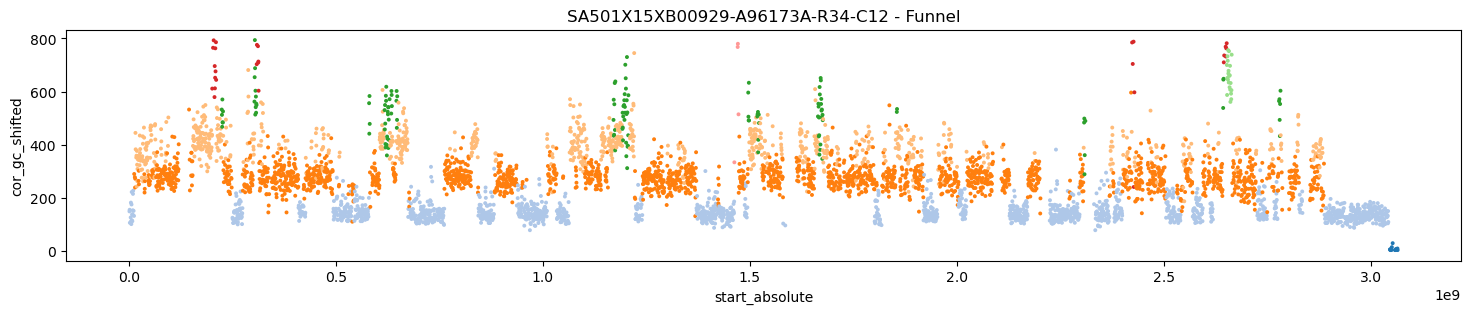

In [21]:
cellplot = 'SA501X15XB00929-A96173A-R34-C12'
plt.figure(figsize = (18,3))
sns.scatterplot(x = 'start_absolute', y = 'cor_gc_shifted', 
				data = noout[noout['cell_id'] == cellplot], hue = 'state', palette = 'tab20',
		s = 8, linewidth = 0, legend = False)
plt.title(f'{cellplot} - Funnel')
# plt.figure(figsize = (18,3))
# sns.scatterplot(x = 'start_absolute', y = 'cor_gc_shifted', 
# 				data = noout[noout['cell_id'] == cellplot], hue = 'map_cn_segment', palette = 'tab20',
# 		s = 8, linewidth = 0, legend = True)
# plt.title(f'{cellplot} - NB')

In [22]:
norm_data.groupby('cell_id').agg({'segmentID_nb': 'nunique', 'segmentID_funnel': 'nunique'}).sort_values('segmentID_funnel', ascending=False)

,segmentID_nb,segmentID_funnel
cell_id,,
SA501X15XB00929-A96173A-R34-C12,123,295
SA501X15XB00929-A96173A-R05-C67,288,265
SA501X15XB00929-A96173A-R24-C28,181,238
SA501X15XB00929-A96173A-R21-C41,207,220
SA501X15XB00929-A96173A-R21-C54,165,214
...,...,...
SA501X15XB00929-A96173A-R23-C34,109,99
SA501X15XB00929-A96173A-R36-C49,104,98
SA501X15XB00929-A96173A-R36-C22,105,98


In [23]:
# nsegs = pd.melt(norm_data.groupby('cell_id').agg({'segmentID_nb': 'nunique', 'segmentID_funnel': 'nunique'}).reset_index(), 
# 		id_vars='cell_id', value_vars=['segmentID_nb', 'segmentID_funnel'])

# sns.boxplot(data = nsegs, x = 'variable', y = 'value')

## Mappability normalization with expected number of reads

In [24]:
# list_bins = [res_element[1] for res_element in test[0]]
combined_dict_bins = test[1]
combined_dict_segments = test[2]
# list_bins = [res_element[3] for res_element in test[0]]
dict_hmm =  test[3]#{k: v for dict_ in list_bins for k, v in dict_.items()}

dict_hmm_segmentation = test[4]



In [25]:
for k in dict_hmm_segmentation.keys():
	print(dict_hmm[k].disp_)

[[0.67756465]
 [0.00771513]
 [0.00771513]
 [0.00771513]
 [0.00771513]
 [0.00771513]
 [0.00771513]
 [0.00771513]
 [0.00771513]
 [0.00771513]
 [0.00771513]
 [0.00771513]]
[[0.67756465]
 [0.01017373]
 [0.01017373]
 [0.01017373]
 [0.01017373]
 [0.01017373]
 [0.01017373]
 [0.01017373]
 [0.01017373]
 [0.01017373]
 [0.01017373]
 [0.01017373]]
[[0.67756465]
 [0.01670694]
 [0.01670694]
 [0.01670694]
 [0.01670694]
 [0.01670694]
 [0.01670694]
 [0.01670694]
 [0.01670694]
 [0.01670694]
 [0.01670694]
 [0.01670694]]
[[0.67756465]
 [0.00670007]
 [0.00670007]
 [0.00670007]
 [0.00670007]
 [0.00670007]
 [0.00670007]
 [0.00670007]
 [0.00670007]
 [0.00670007]
 [0.00670007]
 [0.00670007]]
[[0.67756465]
 [0.00950006]
 [0.00950006]
 [0.00950006]
 [0.00950006]
 [0.00950006]
 [0.00950006]
 [0.00950006]
 [0.00950006]
 [0.00950006]
 [0.00950006]
 [0.00950006]]
[[0.67756465]
 [0.01403966]
 [0.01403966]
 [0.01403966]
 [0.01403966]
 [0.01403966]
 [0.01403966]
 [0.01403966]
 [0.01403966]
 [0.01403966]
 [0.01403966]
 

In [26]:
segmentation = pd.read_csv(f'{funnel_path}/signatures_dataset/DLP/CNA/persample/SA501_hscn.csv.gz')
segmentation['chr'] = segmentation['chr'].replace({'X' : '23', 'Y' : '24'}).astype(int)
compute_absolute_start(segmentation)
segmentation.head()

,patient,cell_id,chr,start,end,state,copy,state_AS_phased,alleleA,alleleB,...,BAF,state_min,Maj,Min,LOH,phase,state_phase,state_BAF,chr_from,start_absolute
0,SA501,SA501X11XB00529-A96174A-R03-C12,1,1,500000,1,NaN,1|0,NaN,NaN,...,NaN,0.0,1.0,0.0,LOH,A,A-Hom,0.0,0.0,1.0
1,SA501,SA501X11XB00529-A96174A-R03-C12,1,500001,1000000,1,NaN,1|0,NaN,NaN,...,NaN,0.0,1.0,0.0,LOH,A,A-Hom,0.0,0.0,500001.0
2,SA501,SA501X11XB00529-A96174A-R03-C12,1,1000001,1500000,1,0.973550,1|0,NaN,NaN,...,NaN,0.0,1.0,0.0,LOH,A,A-Hom,0.0,0.0,1000001.0
3,SA501,SA501X11XB00529-A96174A-R03-C12,1,1500001,2000000,1,0.938266,1|0,NaN,NaN,...,NaN,0.0,1.0,0.0,LOH,A,A-Hom,0.0,0.0,1500001.0
4,SA501,SA501X11XB00529-A96174A-R03-C12,1,2000001,2500000,1,1.127794,1|0,15.0,0.0,...,0.0,0.0,1.0,0.0,LOH,A,A-Hom,0.0,0.0,2000001.0


In [27]:
tmp = test[0].merge(segmentation[['cell_id', 'start_absolute', 'alleleA', 'alleleB','totalcounts', 'Maj', 'Min', 'BAF']], 
					  on=['cell_id', 'start_absolute'], how='left')[['cell_id', 'start_absolute', 'alleleA', 'alleleB','totalcounts', 'reads', 'cor_gc_shifted', 'state', 'hmm_states', 'segment_id', 'Maj', 'Min', 'BAF']]

tmp.sort_values(['cell_id', 'start_absolute'], inplace=True)
tmp[['nfalleleA','nfalleleB', 'nftotalcounts']] = tmp[['alleleA','alleleB', 'totalcounts']]
tmp[['alleleA','alleleB', 'totalcounts']] = tmp.groupby('cell_id')[['alleleA','alleleB', 'totalcounts']].ffill().bfill()
# tmp.fillna(method='ffill', inplace=True)
tmp['minor_allele'] = tmp[['alleleA','alleleB']].min(axis=1)
tmp['original_BAF'] = tmp['BAF'].copy()
tmp['BAF'] = tmp['minor_allele'] / tmp['totalcounts']

In [28]:
current = tmp[tmp['cell_id'] == cellplot].copy()

In [29]:
from ploidy_utils import *

In [30]:
current

,cell_id,start_absolute,alleleA,alleleB,totalcounts,reads,cor_gc_shifted,state,hmm_states,segment_id,Maj,Min,BAF,nfalleleA,nfalleleB,nftotalcounts,minor_allele,original_BAF
1603921,SA501X15XB00929-A96173A-R34-C12,1.000001e+06,9.0,0.0,9.0,321,148,1,1,0,1.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN
1603922,SA501X15XB00929-A96173A-R34-C12,1.500001e+06,9.0,0.0,9.0,275,154,1,1,0,1.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN
1603923,SA501X15XB00929-A96173A-R34-C12,2.000001e+06,9.0,0.0,9.0,224,105,1,1,0,1.0,0.0,0.0,9.0,0.0,9.0,0.0,0.0
1603924,SA501X15XB00929-A96173A-R34-C12,4.000001e+06,16.0,0.0,16.0,181,125,1,1,0,1.0,0.0,0.0,16.0,0.0,16.0,0.0,0.0
1603925,SA501X15XB00929-A96173A-R34-C12,4.500001e+06,26.0,0.0,26.0,260,181,1,1,0,1.0,0.0,0.0,26.0,0.0,26.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609054,SA501X15XB00929-A96173A-R34-C12,3.060500e+09,11.0,0.0,11.0,2,2,0,0,137,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN
1609055,SA501X15XB00929-A96173A-R34-C12,3.061000e+09,11.0,0.0,11.0,6,6,0,0,137,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN
1609056,SA501X15XB00929-A96173A-R34-C12,3.062000e+09,11.0,0.0,11.0,4,4,0,0,137,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN
1609057,SA501X15XB00929-A96173A-R34-C12,3.064500e+09,11.0,0.0,11.0,8,8,0,0,137,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN


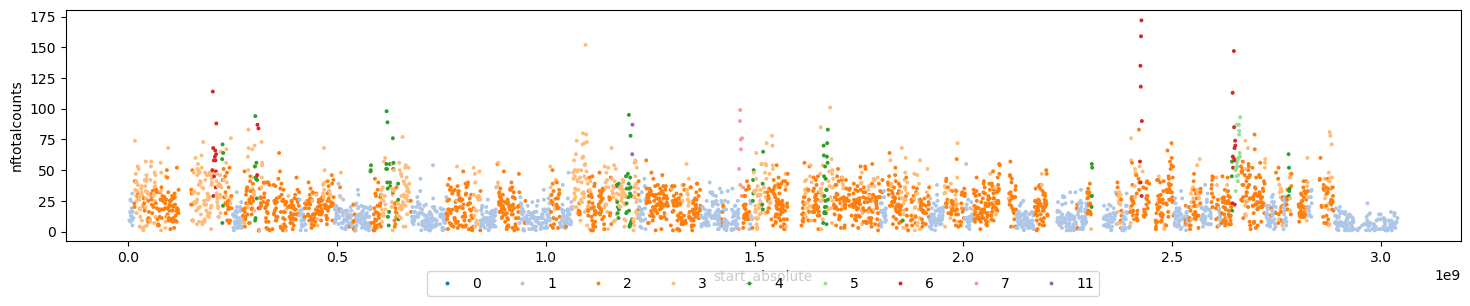

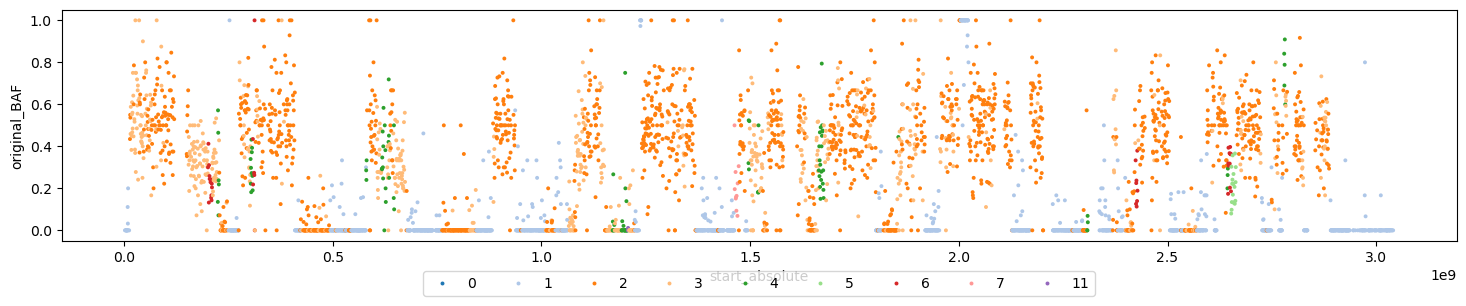

In [31]:
plt.figure(figsize = (18,3))
sns.scatterplot(x = 'start_absolute', y = 'nftotalcounts', data = current,
			s = 8, linewidth = 0, hue = 'state', palette = 'tab20')
# for m in test[1].means_:
# 	plt.axhline(m, color = 'black', linestyle = '--', alpha = 0.5)
plt.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=len(plt.gca().legend_.get_texts()))
plt.figure(figsize = (18,3))
sns.scatterplot(x = 'start_absolute', y = 'original_BAF', data = current,
			s = 8, linewidth = 0, hue = 'state', palette = 'tab20')
# for m in test[1].means_:
# 	plt.axhline(m, color = 'black', linestyle = '--', alpha = 0.5)
plt.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=len(plt.gca().legend_.get_texts()))


0.2462667184533943


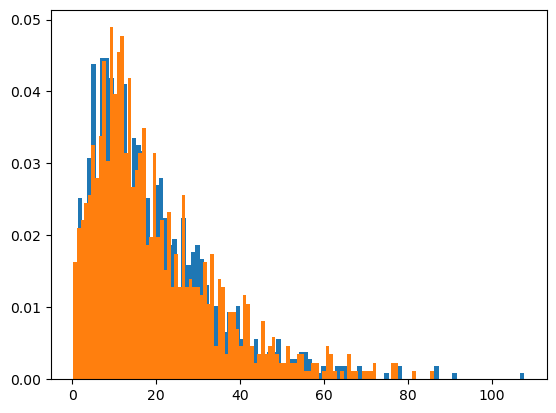

In [34]:
from scipy.stats import gamma
snp_reads = gamma.rvs(1.76, scale = 1/0.09, size = 1000)
len(snp_reads)
plt.hist(snp_reads, bins = 100, density = True);
print(min(snp_reads))

snp_reads = np.random.gamma(1.76, scale = 1/0.09, size = 1000)
len(snp_reads)
plt.hist(snp_reads, bins = 100, density = True);

array([47.99696024, 10.        , 10.21419191, 15.04326564, 39.41588331,
       18.3394478 , 20.63570416, 44.57487647, 24.41795275, 10.        ])

In [30]:
cell = cellplot
test = min((compute_ploidy_solution(current, dict_hmm_segmentation[cell], n) for n in range(1, 4)), key=(lambda v : v[0]))
tot_cnvs = np.arange(0, test[1].n_components)

tot_copies = np.repeat(tot_cnvs, (np.floor(tot_cnvs / 2)).astype(int) + 1)
b_copies = np.zeros(int(np.sum(np.floor(tot_cnvs / 2) + 1 )))
j = 0
for c in tot_cnvs:
	b_range = np.arange(0, np.floor(c/2) + 1)
	for i in range(0, len(b_range)):
		b_copies[j] = int(b_range[i])
		j = j + 1
b_copies = b_copies.astype(int)
a_copies = tot_copies - b_copies

test[2]['map_totcn_segment'] = tot_copies[test[2]['map_cn_segment'].values]
test[2]['map_Acn_segment'] = a_copies[test[2]['map_cn_segment'].values]
test[2]['map_Bcn_segment'] = b_copies[test[2]['map_cn_segment'].values]

KeyError: 'hmm_states_step1'

<Axes: xlabel='start_absolute', ylabel='BAF'>

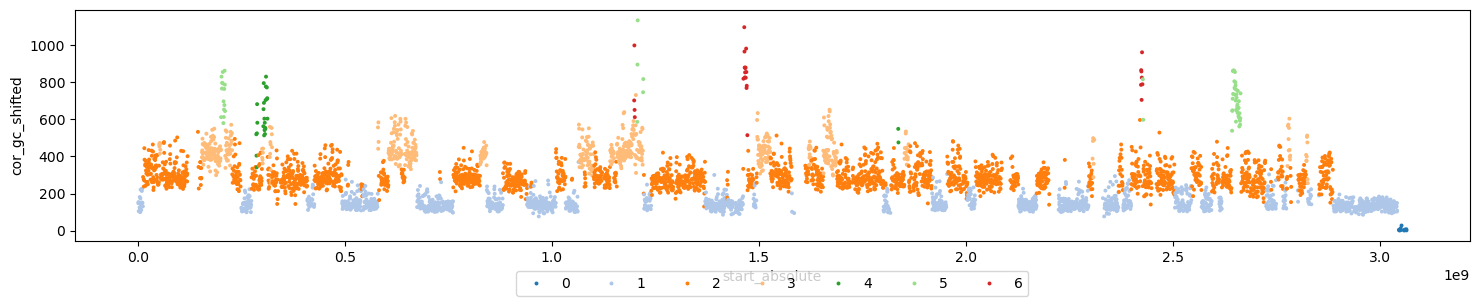

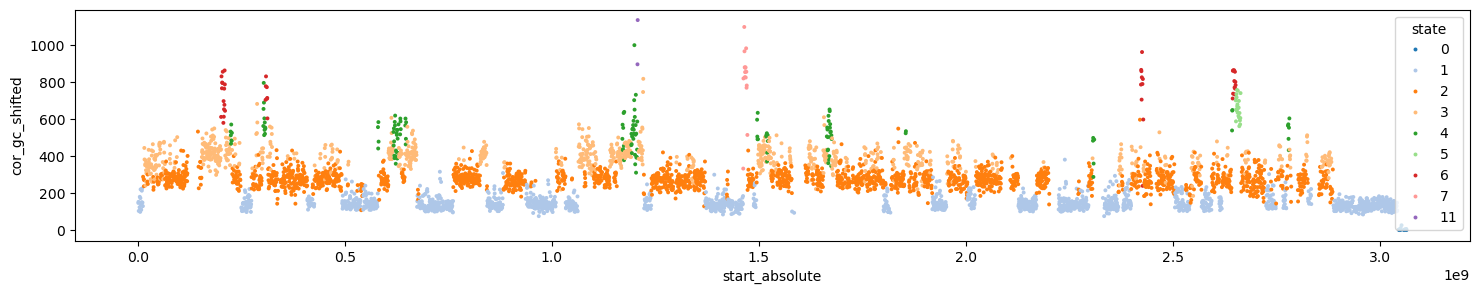

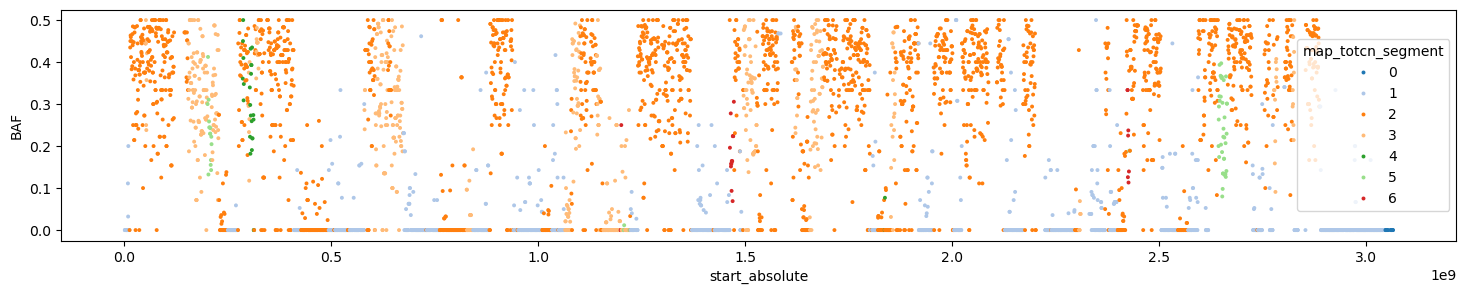

In [56]:
data_plot = test[2]#final_results[final_results['cell_id'] == 'cell_43'].copy()
# data_plot = data_plot[data_plot['hmm_states'] != 0]
plt.figure(figsize = (18,3))
sns.scatterplot(x = 'start_absolute', y = 'cor_gc_shifted', data = data_plot,
			s = 8, linewidth = 0, hue = 'map_totcn_segment', palette = 'tab20')
# for m in test[1].means_:
# 	plt.axhline(m, color = 'black', linestyle = '--', alpha = 0.5)
plt.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=len(plt.gca().legend_.get_texts()))

plt.figure(figsize = (18,3))
sns.scatterplot(x = 'start_absolute', y = 'cor_gc_shifted', data = data_plot,
			s = 8, linewidth = 0, hue = 'state', palette = 'tab20')


plt.figure(figsize = (18,3))
sns.scatterplot(x = 'start_absolute', y = 'BAF', data = data_plot,
			s = 8, linewidth = 0, hue = 'map_totcn_segment', palette = 'tab20')

In [71]:
data_plot

,cell_id,start_absolute,alleleA,alleleB,totalcounts,reads,cor_gc_shifted,state,hmm_states,segment_id,...,nfalleleB,nftotalcounts,minor_allele,original_BAF,test_hmm,map_cn_segment,map_totcn_segment,map_Acn_segment,map_Bcn_segment,nfBAF
1603921,SA501X15XB00929-A96173A-R34-C12,1.000001e+06,9.0,0.0,9.0,321,148,1,1,0,...,NaN,NaN,0.0,NaN,1,1,1,1,0,NaN
1603922,SA501X15XB00929-A96173A-R34-C12,1.500001e+06,9.0,0.0,9.0,275,154,1,1,0,...,NaN,NaN,0.0,NaN,1,1,1,1,0,NaN
1603923,SA501X15XB00929-A96173A-R34-C12,2.000001e+06,9.0,0.0,9.0,224,105,1,1,0,...,0.0,9.0,0.0,0.0,1,1,1,1,0,0.0
1603924,SA501X15XB00929-A96173A-R34-C12,4.000001e+06,16.0,0.0,16.0,181,125,1,1,0,...,0.0,16.0,0.0,0.0,1,1,1,1,0,0.0
1603925,SA501X15XB00929-A96173A-R34-C12,4.500001e+06,26.0,0.0,26.0,260,181,1,1,0,...,0.0,26.0,0.0,0.0,1,1,1,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609054,SA501X15XB00929-A96173A-R34-C12,3.060500e+09,11.0,0.0,11.0,2,2,0,0,137,...,NaN,NaN,0.0,NaN,0,0,0,0,0,NaN
1609055,SA501X15XB00929-A96173A-R34-C12,3.061000e+09,11.0,0.0,11.0,6,6,0,0,137,...,NaN,NaN,0.0,NaN,0,0,0,0,0,NaN
1609056,SA501X15XB00929-A96173A-R34-C12,3.062000e+09,11.0,0.0,11.0,4,4,0,0,137,...,NaN,NaN,0.0,NaN,0,0,0,0,0,NaN
1609057,SA501X15XB00929-A96173A-R34-C12,3.064500e+09,11.0,0.0,11.0,8,8,0,0,137,...,NaN,NaN,0.0,NaN,0,0,0,0,0,NaN


In [64]:
mask = np.random.rand(len(current)) < 0.5
mask = mask & (current[''])
data_plot['nfBAF'] = data_plot[['nfalleleA', 'nfalleleB']].min(axis=1) / data_plot['nftotalcounts']
current['nomirror_BAF'] = current['BAF'].copy()
current.loc[mask, 'nomirror_BAF'] = 1 - current.loc[mask, 'nomirror_BAF']

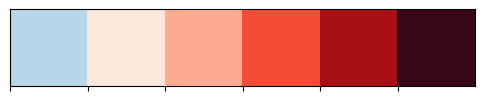

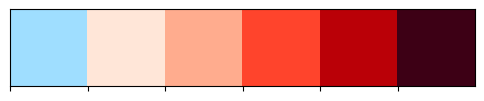

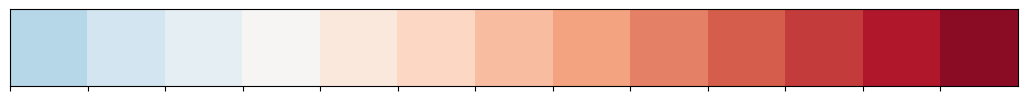

In [74]:
rdbu_palette = sns.color_palette('RdBu_r', 100)[35:][::5]

red_palette = sns.color_palette('Reds', 140)[20::20]
red_palette[4] = red_palette[5]
# red_palette[4] = '#800000'
red_palette[5] = '#370617'
red_palette[0] = rdbu_palette[0]
red_palette[2] = red_palette[1]
red_palette[1] = rdbu_palette[4]
# red_palette.pop(1)
sns.palplot(red_palette)
red_palette =  {k:sns.saturate(v) for k,v in zip([1,2,3,4,5,6], red_palette)}
sns.palplot([v for k,v in red_palette.items()])

sns.palplot(rdbu_palette)


<Axes: xlabel='cor_gc_shifted', ylabel='original_BAF'>

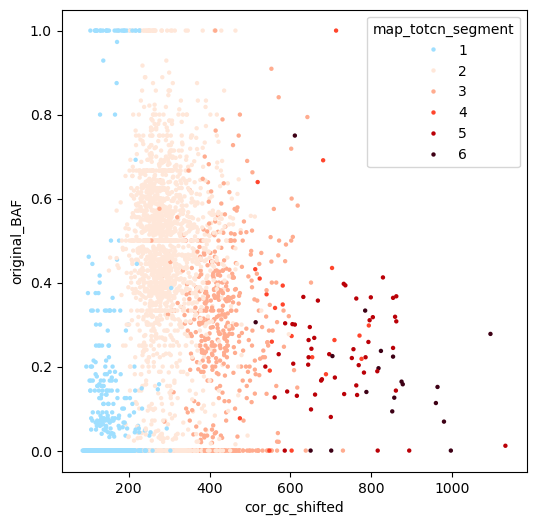

In [80]:
plt.figure(figsize = (6,6))
sns.scatterplot(x = 'cor_gc_shifted', y = 'original_BAF', data = data_plot.dropna(subset='nfBAF'),#[data_plot['start_absolute'] < 0.25*1e9], 
				hue = 'map_totcn_segment', palette = red_palette, s= 10, linewidth = 0, alpha=1)